In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
import numpy as np
from imageio.v2 import imread
from numpy.random import normal, uniform
import sklearn.metrics as error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def frankes_function(x, y):
    z = ((3/4)*np.exp((-1/4)*(9*x-2)**2-(1/4)*(9*y-2)**2)
        + ((3/4)*np.exp((-1/49)*(9*x+1)**2-(1/10)*(9*y+1)))
        + ((1/2)*np.exp((-1/4)*(9*x-7)**2-(1/4)*(9*y-3)**2))
        - ((1/5)*np.exp(-(9*x-4)**2-(9*y-7)**2)))
    return z

def plot_3d(x, y, z, title):
    #Plot (code taken from project description)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.title(title)
    plt.show()

#Make data
# n = 500
# x = np.arange(0, 1, 0.05)
# y = np.arange(0, 1, 0.05) + np.random.normal(0, 0.1, x.shape)

# # x = np.linspace(-1, 3, n)
# # y = np.linspace(-1, 3, n)

# x, y = np.meshgrid(x, y)
# z = frankes_function(x, y) #+ np.random.normal(0, 0.1, x.shape)

# #Test plot
# plot_3d(x, y, z, "Franke's Function Test Plot")

#Real data
#TODO: Smooth switch
# # Load the terrain - again from project description
terrain = imread('SRTM_data_Norway_2.tif')

N = 1000
m = 5 # polynomial order
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x, y = np.meshgrid(x,y)

z = terrain



# a) Ordinary Least Squares on the Franke function
# b) Ridge and dependence on lambda
# c) Lasso
# e) Perform then a bias-variance analysis of the Franke function by studying the MSE value as function of the complexity of your model.

In [23]:
def create_feature_matrix(x, y, degree):
    # Stack x and y into a feature matrix
    X = np.vstack((x.ravel(), y.ravel())).T
    
    # Create polynomial features
    poly = PolynomialFeatures(degree, include_bias=True)
    poly_features = poly.fit_transform(X)
    
    return poly_features

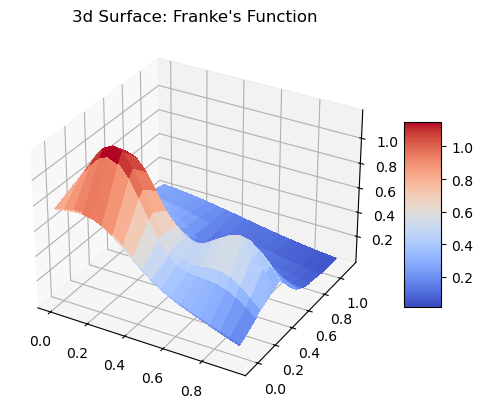

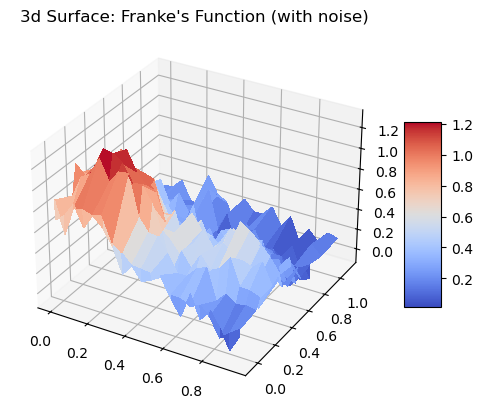

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from random import random, seed

def frankes_function(x, y):
    z = ((3/4)*np.exp((-1/4)*(9*x-2)**2-(1/4)*(9*y-2)**2)
        + ((3/4)*np.exp((-1/49)*(9*x+1)**2-(1/10)*(9*y+1)))
        + ((1/2)*np.exp((-1/4)*(9*x-7)**2-(1/4)*(9*y-3)**2))
        - ((1/5)*np.exp(-(9*x-4)**2-(9*y-7)**2)))
    return z

# x = np.arange(0, 1, 0.05)
# y = np.arange(0, 1, 0.05) + np.random.normal(0, 0.1, x.shape)
# x, y = np.meshgrid(x, y)
# z = frankes_function(x, y) 

z_noise = frankes_function(x, y) + np.random.normal(0, 0.1, x.shape)

#Plot (code taken from project description)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title("3d Surface: Franke's Function")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(x, y, z_noise, cmap=cm.coolwarm, linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title("3d Surface: Franke's Function (with noise)")
plt.show()

z max: 1115
z min: -6
z mean: 512.232697
z shape: (1000, 1000)
z_scaled max: 2.5431369143362463
z_scaled min: -3.600127972657403
z_scaled mean: -2.6005864128819667e-17
z_scaled shape: (1000, 1000)


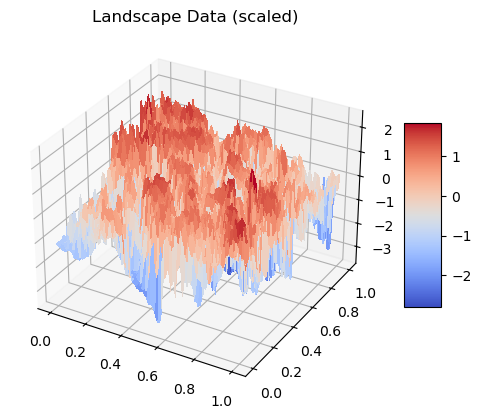

In [26]:
#Quick look at the data values
print(f"z max: {z.max()}")
print(f"z min: {z.min()}")
print(f"z mean: {z.mean()}")
print(f"z shape: {z.shape}")

scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

#plot_3d(x_scaled, y_scaled, z_scaled, "Franke's Function w/ mean centering")

#Plot (code taken from project description)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(x, y, z_scaled, cmap=cm.coolwarm, linewidth=0, antialiased=False)

#Quick look at the data values
print(f"z_scaled max: {z_scaled.max()}")
print(f"z_scaled min: {z_scaled.min()}")
print(f"z_scaled mean: {z_scaled.mean()}")
print(f"z_scaled shape: {z_scaled.shape}")

#ax.set_zlim(-0.10, 1.40)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title("Landscape Data (scaled)")
plt.show()

z_scaled = z_scaled.ravel() # Flatten z into a 1D array for regression (from ChatGPT)

In [18]:
def MSE(z_data, z_model):
    n = np.size(z_model)  # Number of data points
    return np.sum((z_data - z_model)**2)/n

# Ridge Regression using matrix inversion
def Beta_ridge_regression(X, z, lmb): 
    I = np.identity(X.shape[1])

    return np.linalg.pinv(X.T.dot(X) + lmb*I) @ X.T.dot(z)

def Calculate_y_ridge(X, beta):
    return X.dot(beta)

Degree: 1
MSE (training): 0.036811248715268335
MSE (test): 0.049102281696215166
r2 (training): 0.6079094312488692
r2 (test): 0.612083582415498

Degree: 2
MSE (training): 0.029965169550550674
MSE (test): 0.03387849420838314
r2 (training): 0.6906857850463868
r2 (test): 0.7119918023978188

Degree: 3
MSE (training): 0.01984836760112522
MSE (test): 0.019321263141629942
r2 (training): 0.8042737807171436
r2 (test): 0.8117307783478792

Degree: 4
MSE (training): 0.014813133607691589
MSE (test): 0.01885087831451821
r2 (training): 0.8532224596098537
r2 (test): 0.8181253600242915

Degree: 5
MSE (training): 0.012396317972219257
MSE (test): 0.012606451688595472
r2 (training): 0.8787488921719152
r2 (test): 0.872926065837835



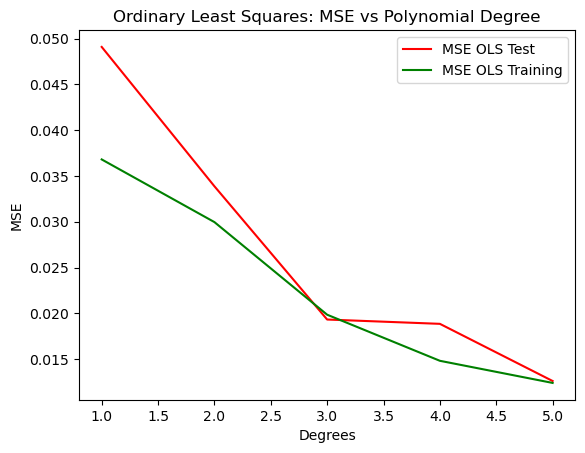

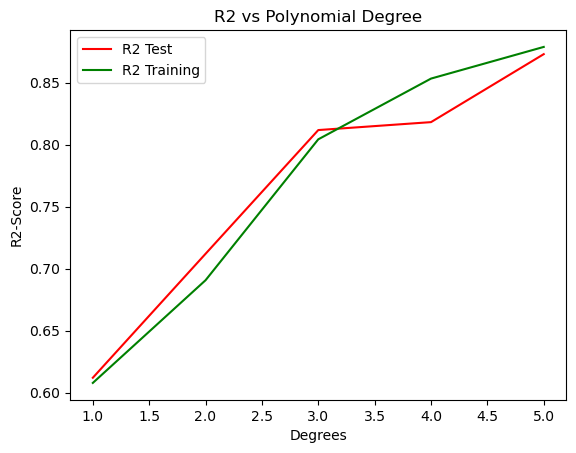

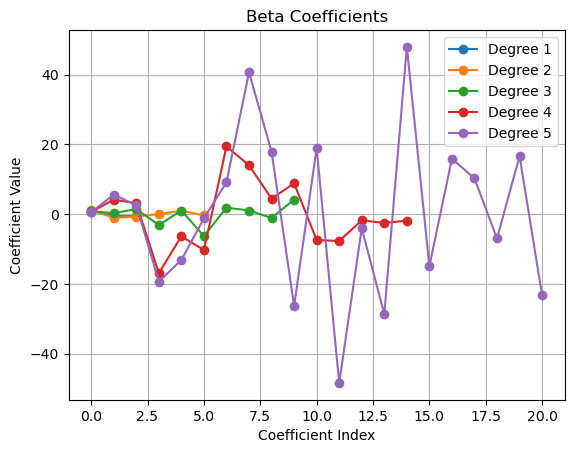

In [18]:
#Polynomials up to 5th order
def create_feature_matrix(x, y, degree):
    # Stack x and y into a feature matrix
    X = np.vstack((x.ravel(), y.ravel())).T
    
    # Create polynomial features
    poly = PolynomialFeatures(degree, include_bias=True)
    poly_features = poly.fit_transform(X)
    
    return poly_features

def MSE(z_data, z_model):
    n = np.size(z_model)  # Number of data points
    return np.sum((z_data - z_model)**2)/n


#z = z_noise.ravel()
z = z.ravel()
train_MSEs = []
test_MSEs = []
train_r2s = []
test_r2s = []
betas = []

degrees = range(1,6)
for order in degrees:
    feature_matrix = create_feature_matrix(x, y, order)

    X_train, X_test, z_train, z_test = train_test_split(feature_matrix, z, test_size=0.2)

    #Matrix inversion
    beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train) #Pseudo inverse to handle singular matrices
    betas.append(beta)

    #Make the prediction
    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    #OLS
    training_mse = MSE(z_train, z_tilde)
    test_mse = MSE(z_test, z_predict)

    train_MSEs.append(training_mse)
    test_MSEs.append(test_mse)

    print(f"Degree: {order}")
    print(f"MSE (training): {training_mse}")
    print(f"MSE (test): {test_mse}")

    #R2
    r2_training = error.r2_score(z_train, z_tilde)
    r2_test = error.r2_score(z_test, z_predict)
    print(f"r2 (training): {r2_training}")
    print(f"r2 (test): {r2_test}")
    print()

    train_r2s.append(r2_training)
    test_r2s.append(r2_test)

#Plot the mse vs. degrees
plt.figure()
plt.title("Ordinary Least Squares: MSE vs Polynomial Degree")
plt.plot(degrees, test_MSEs, 'r', label = 'MSE OLS Test')
plt.plot(degrees, train_MSEs, 'g', label = 'MSE OLS Training')

plt.xlabel('Degrees')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Plot R2 vs. degrees
plt.figure()
plt.title("R2 vs Polynomial Degree")
plt.plot(degrees, test_r2s, 'r', label = 'R2 Test')
plt.plot(degrees, train_r2s, 'g', label = 'R2 Training')

plt.xlabel('Degrees')
plt.ylabel('R2-Score')
plt.legend()
plt.show()

for i in range(len(betas)):
    plt.plot(betas[i], marker='o', label=f'Degree {degrees[i]}')

# Adding plot details
plt.title('Beta Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+00, tolerance: 8.119e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+00, tolerance: 8.119e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e+00, to

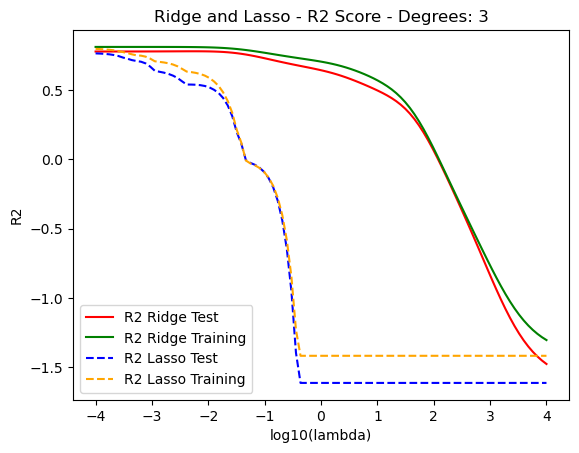

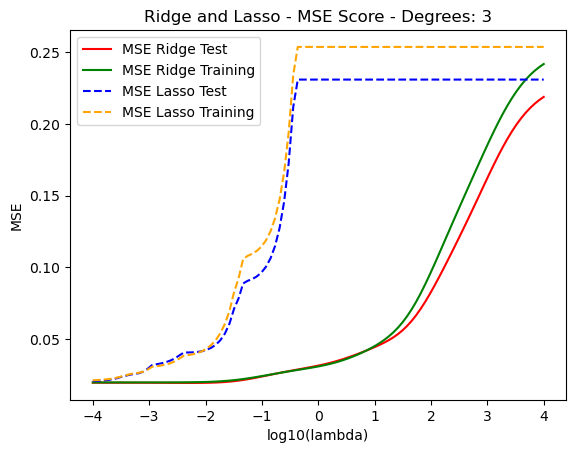

In [29]:
# Ridge and Lasso Regression using matrix inversion
def Beta_ridge_regression(X, z, lmb): 
    I = np.identity(X.shape[1])

    return np.linalg.pinv(X.T.dot(X) + lmb*I) @ X.T.dot(z)

def Calculate_y_ridge(X, beta):
    return X.dot(beta)

degree = 3
feature_matrix = create_feature_matrix(x, y, degree)
X_train, X_test, z_train, z_test = train_test_split(feature_matrix, z, test_size=0.2)

training_ridge_mses = []
test_ridge_mses = []
training_ridge_r2s = []
test_ridge_r2s = []
betas_ridge = []

training_lasso_mses = []
test_lasso_mses = []
training_lasso_r2s = []
test_lasso_r2s = []

lambdas = (0.0001, 0.001, 0.01, 0.1, 1.0)
nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]

    #Ridge
    beta_hat_ridge = Beta_ridge_regression(X_train, z_train, lmb)
    betas_ridge.append(beta_hat_ridge)
    z_tilde_ridge = Calculate_y_ridge(X_train, beta_hat_ridge)
    z_predict_ridge = Calculate_y_ridge(X_test, beta_hat_ridge)

    train_mse = error.mean_squared_error(z_train, z_tilde_ridge)
    test_mse = error.mean_squared_error(z_test, z_predict_ridge)
    training_ridge_mses.append(train_mse)
    test_ridge_mses.append(test_mse)

    r2_train = error.r2_score(z_train, z_tilde_ridge)
    r2_test = error.r2_score(z_test, z_predict_ridge)
    training_ridge_r2s.append(r2_train)
    test_ridge_r2s.append(r2_test)

    #Lasso
    RegLasso = linear_model.Lasso(lmb, fit_intercept=False)
    RegLasso.fit(X_train, z_train)
    y_tilde_lasso = RegLasso.predict(X_train)
    y_predict_lasso = RegLasso.predict(X_test)

    training_lasso_mses.append(error.mean_squared_error(z_train, y_tilde_lasso))
    test_lasso_mses.append(error.mean_squared_error(z_test, y_predict_lasso))

    training_lasso_r2s.append(error.r2_score(z_train, y_tilde_lasso))
    test_lasso_r2s.append(error.r2_score(z_test, y_predict_lasso))

# R2 Ridge/Lasso plots
plt.figure()
plt.title("Ridge and Lasso - R2 Score - Degrees: " + str(degree))

plt.plot(np.log10(lambdas), test_ridge_r2s, 'r', label = 'R2 Ridge Test')
plt.plot(np.log10(lambdas), training_ridge_r2s, 'g', label = 'R2 Ridge Training')

plt.plot(np.log10(lambdas), test_lasso_r2s, 'b--', label = 'R2 Lasso Test')
plt.plot(np.log10(lambdas), training_lasso_r2s, '--', color='orange', label = 'R2 Lasso Training')

plt.xlabel('log10(lambda)')
plt.ylabel('R2')
plt.legend()
plt.show()

# MSE Ridge/Lasso plots
plt.figure()
plt.title("Ridge and Lasso - MSE Score - Degrees: " + str(degree))

plt.plot(np.log10(lambdas), test_ridge_mses, 'r', label = 'MSE Ridge Test')
plt.plot(np.log10(lambdas), training_ridge_mses, 'g', label = 'MSE Ridge Training')

plt.plot(np.log10(lambdas), test_lasso_mses, 'b--', label = 'MSE Lasso Test')
plt.plot(np.log10(lambdas), training_lasso_mses, '--', color='orange', label = 'MSE Lasso Training')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [2]:
#Polynomials up to 5th order
train_MSEs = []
test_MSEs = []
train_r2s = []
test_r2s = []
betas = []
degrees = range(1,6)
for order in degrees:

    feature_matrix = create_feature_matrix(x, y, order)

    z_scaled = z_scaled.ravel() # Flatten z into a 1D array for regression (from ChatGPT)
    X_train, X_test, z_train, z_test = train_test_split(feature_matrix, z_scaled, test_size=0.2)

    #Matrix inversion
    beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train) #Pseudo inverse to handle singular matrices

    #Make the prediction
    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    #OLS
    training_mse = MSE(z_train, z_tilde)
    test_mse = MSE(z_test, z_predict)

    train_MSEs.append(training_mse)
    test_MSEs.append(test_mse)

    # print(training_mse)
    # print(test_mse)
    # print(f"Max difference in training set: {np.max(np.abs(z_train - z_tilde))}")
    # print(f"Max difference in test set: {np.max(np.abs(z_test - z_predict))}")

    #R2
    r2_training = error.r2_score(z_train, z_tilde)
    r2_test = error.r2_score(z_test, z_predict)
    # print(f"r2 training: {r2_training}")
    # print(f"r2 test: {r2_test}")

    train_r2s.append(r2_training)
    test_r2s.append(r2_test)

    # #For testing - plotting the fitted line over the data points:
    # Simple_test_data.Create_test_plot(order)

    training_ridge_mses = []
    test_ridge_mses = []
    training_ridge_r2s = []
    test_ridge_r2s = []
    betas_ridge = []

    training_lasso_mses = []
    test_lasso_mses = []
    training_lasso_r2s = []
    test_lasso_r2s = []

    lambdas = (0.0001, 0.001, 0.01, 0.1, 1.0)
    nlambdas = 100
    lambdas = np.logspace(-4, 4, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]

        #Ridge
        beta_hat_ridge = Beta_ridge_regression(X_train, z_train, lmb)
        betas_ridge.append(beta_hat_ridge)
        z_tilde_ridge = Calculate_y_ridge(X_train, beta_hat_ridge)
        z_predict_ridge = Calculate_y_ridge(X_test, beta_hat_ridge)

        training_ridge_mses.append(error.mean_squared_error(z_train, z_tilde_ridge))
        test_ridge_mses.append(error.mean_squared_error(z_test, z_predict_ridge))

        training_ridge_r2s.append(error.r2_score(z_train, z_tilde_ridge))
        test_ridge_r2s.append(error.r2_score(z_test, z_predict_ridge))

        #Lasso
        RegLasso = linear_model.Lasso(lmb, fit_intercept=False)
        RegLasso.fit(X_train, z_train)
        y_tilde_lasso = RegLasso.predict(X_train)
        y_predict_lasso = RegLasso.predict(X_test)

        training_lasso_mses.append(error.mean_squared_error(z_train, y_tilde_lasso))
        test_lasso_mses.append(error.mean_squared_error(z_test, y_predict_lasso))

        training_lasso_r2s.append(error.r2_score(z_train, y_tilde_lasso))
        test_lasso_r2s.append(error.r2_score(z_test, y_predict_lasso))

    # MSE plots
    plt.figure()
    plt.title("Ridge and Lasso - Mean Square Error - Degrees: " + str(order))

    plt.plot(np.log10(lambdas), test_ridge_mses, 'r', label = 'MSE Ridge Test')
    plt.plot(np.log10(lambdas), training_ridge_mses, 'g', label = 'MSE Ridge Training')

    #TODO: Easier to read with same colour for the test and training, or not?
    plt.plot(np.log10(lambdas), test_lasso_mses, 'b--', label = 'MSE Lasso Test')
    plt.plot(np.log10(lambdas), training_lasso_mses, '--', label = 'MSE Lasso Training')

    plt.xlabel('log10(lambda)')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    # R2 Ridge plots
    plt.figure()
    plt.title("Ridge and Lasso - R2 Score - Degrees: " + str(order))

    plt.plot(np.log10(lambdas), test_ridge_r2s, 'r', label = 'R2 Ridge Test')
    plt.plot(np.log10(lambdas), training_ridge_r2s, 'g', label = 'R2 Ridge Training')

    plt.plot(np.log10(lambdas), test_lasso_r2s, 'b--', label = 'MSE Lasso Test')
    plt.plot(np.log10(lambdas), training_lasso_r2s, '--', color='orange', label = 'MSE Lasso Training')

    plt.xlabel('log10(lambda)')
    plt.ylabel('R2')
    plt.legend()
    plt.show()


# #TODO: Make labels and title better
# #Plot the mse vs. degrees
plt.figure()
plt.title("Ordinary Least Squares: MSE vs Polynomial Degree")
plt.plot(degrees, test_MSEs, 'r', label = 'MSE OLS Test')
plt.plot(degrees, train_MSEs, 'g', label = 'MSE OLS Training')

plt.xlabel('Degrees')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Plot the r2 scores vs. degrees
plt.figure()
plt.title("R2 vs Polynomial Degree")
plt.plot(degrees, test_r2s, 'r', label = 'R2 Test')
plt.plot(degrees, train_r2s, 'g', label = 'R2 Training')

plt.xlabel('Degrees')
plt.ylabel('R2-Score')
plt.legend()
plt.show()

# #From ChatGPT:
# #Plot beta vs degrees
for i in range(len(betas)):
    plt.plot(betas[i], marker='o', label=f'Degree {degrees[i]}')

# Adding plot details
plt.title('Beta Coefficients as a Function of Polynomial Degree')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()





NameError: name 'create_feature_matrix' is not defined

# e) Bootstrap

Polynomial degree: 0
Error: 0.08585201741355096
Bias^2: 0.08556674567936436
Var: 0.00028527173418662575
0.08585201741355096 >= 0.08556674567936436 + 0.00028527173418662575 = 0.08585201741355099

Polynomial degree: 1
Error: 0.03969074865889778
Bias^2: 0.03937024623641755
Var: 0.0003205024224802387
0.03969074865889778 >= 0.03937024623641755 + 0.0003205024224802387 = 0.03969074865889779

Polynomial degree: 2
Error: 0.019958555085310685
Bias^2: 0.01933112377175456
Var: 0.000627431313556129
0.019958555085310685 >= 0.01933112377175456 + 0.000627431313556129 = 0.019958555085310692

Polynomial degree: 3
Error: 0.015781992828215678
Bias^2: 0.011851301349171329
Var: 0.0039306914790443485
0.015781992828215678 >= 0.011851301349171329 + 0.0039306914790443485 = 0.015781992828215678

Polynomial degree: 4
Error: 180.0824780626808
Bias^2: 0.6344562186239149
Var: 179.44802184405688
180.0824780626808 >= 0.6344562186239149 + 179.44802184405688 = 180.0824780626808



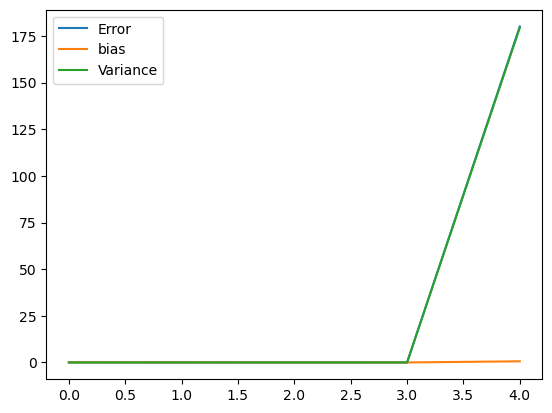

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(2018)

# def frankes_function(x, y):
#     z = ((3/4)*np.exp((-1/4)*(9*x-2)**2-(1/4)*(9*y-2)**2)
#         + ((3/4)*np.exp((-1/49)*(9*x+1)**2-(1/10)*(9*y+1)))
#         + ((1/2)*np.exp((-1/4)*(9*x-7)**2-(1/4)*(9*y-3)**2))
#         - ((1/5)*np.exp(-(9*x-4)**2-(9*y-7)**2)))
#     return z

# def create_feature_matrix(x, y, degree):
#     # Stack x and y into a feature matrix
#     X = np.vstack((x.ravel(), y.ravel())).T
    
#     # Create polynomial features
#     poly = PolynomialFeatures(degree, include_bias=True)
#     poly_features = poly.fit_transform(X)
    
#     return poly_features

# #Make data
# x = np.arange(0, 1, 0.05)
# y = np.arange(0, 1, 0.05) + np.random.normal(0, 0.1, x.shape)

# x, y = np.meshgrid(x, y)
# z = frankes_function(x, y)

# z = z.ravel() # Flatten z into a 1D array for regression (from ChatGPT)
# #X = np.vstack((x.ravel(), y.ravel(), z.ravel())).T

x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05) 

x, y = np.meshgrid(x, y)
z = frankes_function(x, y) + np.random.normal(0, 0.1, x.shape)

z = z.ravel()

n = 500
n_bootstraps = 100
degree = 2  # A quite high value, just to show.
noise = 0.1
max_degrees = 5

errors = np.zeros(max_degrees)
biases = np.zeros(max_degrees)
variances = np.zeros(max_degrees)
polydegrees = np.zeros(max_degrees)
for degree in range(max_degrees):
    feature_matrix = create_feature_matrix(x, y, degree)

    z = z.ravel() # Flatten z into a 1D array for regression (from ChatGPT)
    X_train, X_test, z_train, z_test = train_test_split(feature_matrix, z, test_size=0.2)

    beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train) #Pseudo inverse to handle singular matrices

    #Make the prediction
    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    # Combine x transformation and model into one operation.
    # Not necessary, but convenient.
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))

    # The following (m x n_bootstraps) matrix holds the column vectors z_pred
    # for each bootstrap iteration.
    z_pred = np.empty((z_test.shape[0], n_bootstraps))  # Adjust for 3D case

    # Perform bootstrapping
    for i in range(n_bootstraps):
        # Resample the training data
        X_resampled, z_resampled = resample(X_train, z_train)
        model.fit(X_resampled, z_resampled)
        # Fit the model on resampled data and evaluate on the same test data
        z_pred[:, i] = model.fit(X_resampled, z_resampled).predict(X_test).ravel()  # Prediction in 3D

    # Reshape z_test to match the dimensions of z_pred for broadcasting
    z_test_reshaped = z_test.reshape(-1, 1)  # Reshape to (80, 1)

    polydegrees[degree] = degree
    # Error calculation (mean squared error across all bootstrap samples and test points)
    error = np.mean(np.mean((z_test_reshaped - z_pred)**2, axis=1, keepdims=True))
    errors[degree] = error
    # Bias^2 calculation (bias as the difference between true values and the mean prediction)
    bias = np.mean((z_test_reshaped - np.mean(z_pred, axis=1, keepdims=True))**2)
    biases[degree] = bias
    # Variance calculation (variance of predictions across bootstrap samples)
    variance = np.mean(np.var(z_pred, axis=1,keepdims=True))
    variances[degree] = variance

    # Note: Expectations and variances taken w.r.t. different training
    # data sets, hence the axis=1. Subsequent means are taken across the test data
    # set in order to obtain a total value, but before this we have error/bias/variance
    # calculated per data point in the test set.
    # Note 2: The use of keepdims=True is important in the calculation of bias as this 
    # maintains the column vector form. Dropping this yields very unexpected results.
    # error = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    # bias = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    # variance = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree)
    print('Error:', error)
    print('Bias^2:', bias)
    print('Var:', variance)
    print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))
    print()

plt.plot(polydegrees, errors, label='Error')
plt.plot(polydegrees, biases, label='bias')
plt.plot(polydegrees, variances, label='Variance')
plt.legend()
plt.show()

Error: 30989.51113648287
Bias^2: 30989.388107746378
Var: 0.12302873647825188
30989.51113648287 >= 30989.388107746378 + 0.12302873647825188 = 30989.511136482855


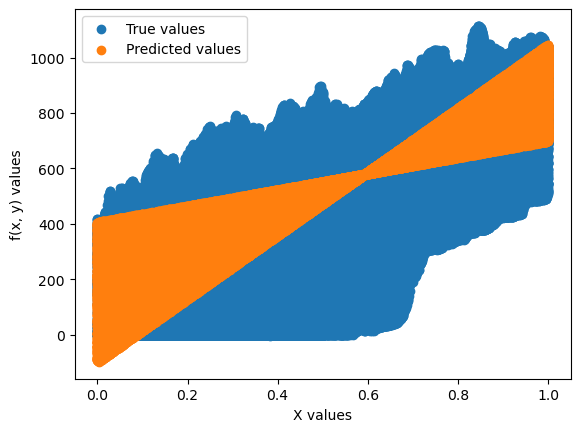

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(2018)

n = 500
n_boostraps = 100
degree = 18
noise = 0.1

# Create two-dimensional data set (x, y).
# x = np.linspace(-1, 3, n)
# y = np.linspace(-1, 3, n)
# X = np.vstack((x, y)).T  # Combine x and y into a 2D feature matrix.

# z = ((3/4)*np.exp((-1/4)*(9*x-2)**2-(1/4)*(9*y-2)**2)
#     + ((3/4)*np.exp((-1/49)*(9*x+1)**2-(1/10)*(9*y+1)))
#     + ((1/2)*np.exp((-1/4)*(9*x-7)**2-(1/4)*(9*y-3)**2))
#     - ((1/5)*np.exp(-(9*x-4)**2-(9*y-7)**2))) + np.random.normal(0, 0.1, x.shape)

# The target function f(x, y) can be a function of both x and y
#z = np.exp(-x**2) + 1.5 * np.exp(-(y-2)**2) + np.random.normal(0, 0.1, x.shape)

terrain = imread('SRTM_data_Norway_2.tif')

N = 1000
m = 5 # polynomial order
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])

x, y = np.meshgrid(x, y)
X = np.vstack((x.ravel(), y.ravel())).T

#X = np.vstack((x, y)).T 
z = terrain.ravel()

# Split into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
#poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
#X_poly = poly.fit_transform(X)
# Combine polynomial transformation and linear regression model
model = make_pipeline(PolynomialFeatures(degree=degree, interaction_only=True), LinearRegression(fit_intercept=False))

# The following (m x n_boostraps) matrix holds the column vectors y_pred
# for each bootstrap iteration.
z_pred = np.empty((z_test.shape[0], n_boostraps))
for i in range(n_boostraps):
    X_, z_ = resample(X_train, z_train)

    # Evaluate the new model on the same test data each time.
    z_pred[:, i] = model.fit(X_, z_).predict(X_test).ravel()

# Calculate error (mean squared error for each point)
error = np.mean(np.mean((z_test.reshape(-1, 1) - z_pred)**2, axis=1))

# Calculate bias^2 (squared difference between true values and the mean prediction)
bias = np.mean((z_test.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2)

# Calculate variance (variance of predictions for each test point)
variance = np.mean(np.var(z_pred, axis=1))

# Calculate error, bias^2, and variance
#error = np.mean(np.mean((z_test - z_pred)**2, axis=1, keepdims=True))
#bias = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2)
#variance = np.mean(np.var(z_pred, axis=1, keepdims=True))
print('Error:', error)
print('Bias^2:', bias)
print('Var:', variance)
print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))

# Visualization
plt.scatter(X_test[:, 0], z_test, label='True values')  # Plot test points
plt.scatter(X_test[:, 0], np.mean(z_pred, axis=1), label='Predicted values')
plt.xlabel('X values')
plt.ylabel('f(x, y) values')
plt.legend()
plt.show()





Bootstrap Statistics :
original           bias      std. error
 99.9801  14.8373        99.9795        0.146885


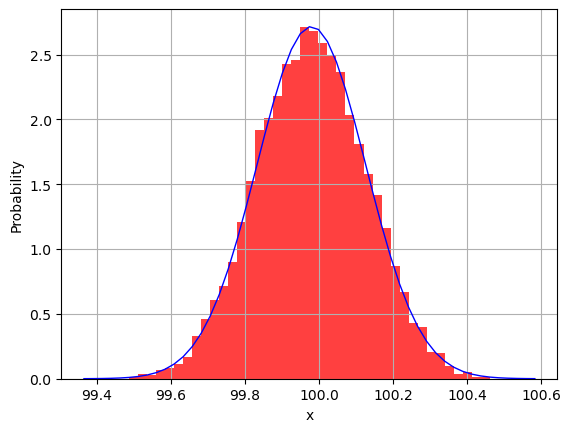

In [3]:
%matplotlib inline

import numpy as np
from time import time
from scipy.stats import norm
import matplotlib.pyplot as plt

# Returns mean of bootstrap samples 
# Bootstrap algorithm
def bootstrap(data, datapoints):
    t = np.zeros(datapoints)
    n = len(data)
    # non-parametric bootstrap         
    for i in range(datapoints):
        t[i] = np.mean(data[np.random.randint(0,n,n)])
    # analysis    
    print("Bootstrap Statistics :")
    print("original           bias      std. error")
    print("%8g %8g %14g %15g" % (np.mean(data), np.std(data),np.mean(t),np.std(t)))
    return t

# We set the mean value to 100 and the standard deviation to 15
mu, sigma = 100, 15
datapoints = 10000
# We generate random numbers according to the normal distribution
x = mu + sigma*np.random.randn(datapoints)
# bootstrap returns the data sample                                    
t = bootstrap(x, datapoints)

# the histogram of the bootstrapped data (normalized data if density = True)
n, binsboot, patches = plt.hist(t, 50, density=True, facecolor='red', alpha=0.75)
# add a 'best fit' line  
y = norm.pdf(binsboot, np.mean(t), np.std(t))
lt = plt.plot(binsboot, y, 'b', linewidth=1)
plt.xlabel('x')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

n = 500
n_bootstraps = 100
#degree = 2  # A quite high value, just to show.
noise = 0.1
max_degrees = 5

errors = np.zeros(max_degrees)
biases = np.zeros(max_degrees)
variances = np.zeros(max_degrees)
polydegrees = np.zeros(max_degrees)
for degree in range(max_degrees):
    feature_matrix = create_feature_matrix(x, y, degree)

    #z = z.ravel() # Flatten z into a 1D array for regression (from ChatGPT)
    X_train, X_test, z_train, z_test = train_test_split(feature_matrix, z_noise, test_size=0.2)

    #beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train) #Pseudo inverse to handle singular matrices

    # Perform Singular Value Decomposition
    U, s, VT = np.linalg.svd(X_train, full_matrices=False)

    # Compute the inverse of the diagonal matrix of singular values
    S_inv = np.diag(1/s)

    # Compute the beta coefficients using SVD
    beta = VT.T @ S_inv @ U.T @ z_train

    #Make the prediction
    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    # Combine x transformation and model into one operation.
    # Not necessary, but convenient.
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))

    # The following (m x n_bootstraps) matrix holds the column vectors z_pred
    # for each bootstrap iteration.
    z_pred = np.empty((z_test.shape[0], n_bootstraps))  # Adjust for 3D case

    # Perform bootstrapping
    for i in range(n_bootstraps):
        # Resample the training data
        X_resampled, z_resampled = resample(X_train, z_train)
        model.fit(X_resampled, z_resampled)
        # Fit the model on resampled data and evaluate on the same test data
        z_pred[:, i] = model.fit(X_resampled, z_resampled).predict(X_test).ravel()  # Prediction in 3D

    # Reshape z_test to match the dimensions of z_pred for broadcasting
    z_test_reshaped = z_test.reshape(-1, 1)  # Reshape to (80, 1)

    polydegrees[degree] = degree
    # Error calculation (mean squared error across all bootstrap samples and test points)
    error = np.mean(np.mean((z_test_reshaped - z_pred)**2, axis=1, keepdims=True))
    errors[degree] = error
    # Bias^2 calculation (bias as the difference between true values and the mean prediction)
    bias = np.mean((z_test_reshaped - np.mean(z_pred, axis=1, keepdims=True))**2)
    biases[degree] = bias
    # Variance calculation (variance of predictions across bootstrap samples)
    variance = np.mean(np.var(z_pred, axis=1,keepdims=True))
    variances[degree] = variance

    # Note: Expectations and variances taken w.r.t. different training
    # data sets, hence the axis=1. Subsequent means are taken across the test data
    # set in order to obtain a total value, but before this we have error/bias/variance
    # calculated per data point in the test set.
    # Note 2: The use of keepdims=True is important in the calculation of bias as this 
    # maintains the column vector form. Dropping this yields very unexpected results.
    # error = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    # bias = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    # variance = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree)
    print('Error:', error)
    print('Bias^2:', bias)
    print('Var:', variance)
    print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))
    print()

plt.plot(polydegrees, errors, label='Error')
plt.plot(polydegrees, biases, label='bias')
plt.plot(polydegrees, variances, label='Variance')
plt.legend()
plt.show()



ValueError: Found input variables with inconsistent numbers of samples: [400, 20]

# f) k-fold

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.585e-03, tolerance: 3.037e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e-03, tolerance: 3.221e-03
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.727e-03, to

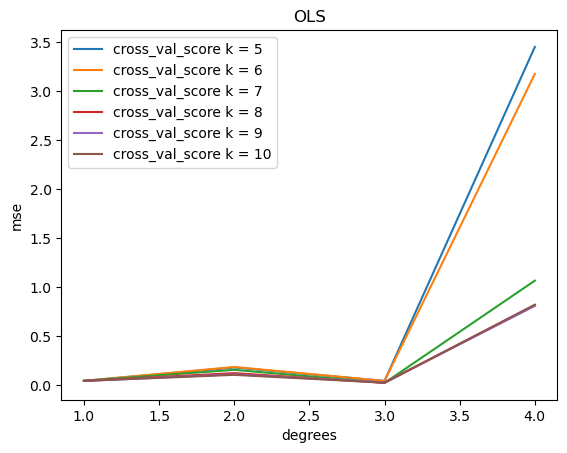

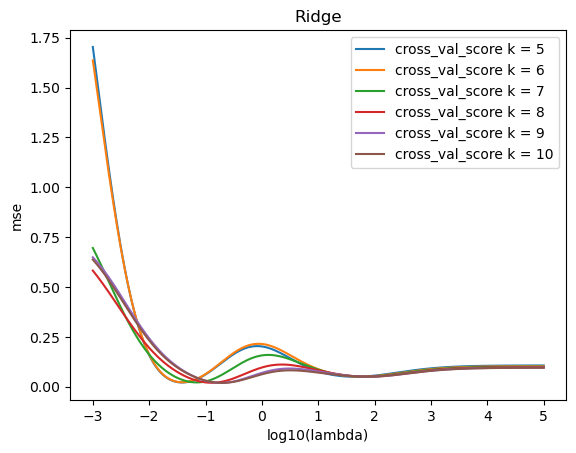

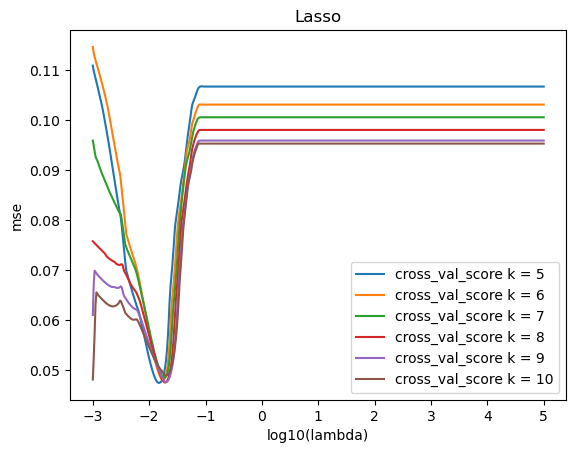

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#Make data
n = 500
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05) + np.random.normal(0, 0.1, x.shape)

# x = np.linspace(-1, 3, n)
# y = np.linspace(-1, 3, n)

x, y = np.meshgrid(x, y)
z = frankes_function(x, y) #+ np.random.normal(0, 0.1, x.shape)

# #Test plot
# plot_3d(x, y, z, "Franke's Function Test Plot")

#Real data
#TODO: Smooth switch
# # Load the terrain - again from project description
# terrain = imread('SRTM_data_Norway_2.tif')

# N = 1000
# m = 5 # polynomial order
# terrain = terrain[:N,:N]
# # Creates mesh of image pixels
# x = np.linspace(0,1, np.shape(terrain)[0])
# y = np.linspace(0,1, np.shape(terrain)[1])
# x, y = np.meshgrid(x,y)

# z = terrain

#From lecture notes
k_folds = range(5,11)
degrees = range(1,5)

ols_k_mses = []
ridge_k_mses = []
lasso_k_mses = []
i = 0
for k in k_folds:
    kfold = KFold(n_splits = k)
    
    #OLS
    estimated_mse_ols = np.zeros(len(degrees))
    j = 0
    for degree in degrees:
        # Decide degree on polynomial to fit
        poly = PolynomialFeatures(degree = degree)

        X = create_feature_matrix(x, y, degree)

        z = z.ravel() # Flatten z into a 1D array for regression (from ChatGPT)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

        ols = LinearRegression()
        estimated_mse_folds = cross_val_score(ols, X, z[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)
        estimated_mse_ols[j] = np.mean(-estimated_mse_folds)

        j += 1

    ols_k_mses.append(estimated_mse_ols)

    #Ridge and Lasso
    # Decide which values of lambda to use
    nlambdas = 500
    lambdas = np.logspace(-3, 5, nlambdas)
    #From lecture notes:
    ## Cross-validation using cross_val_score from sklearn along with KFold
    estimated_mse_ridge = np.zeros(nlambdas)
    estimated_mse_lasso = np.zeros(nlambdas)
    j = 0
    for lmb in lambdas:
        ridge = Ridge(alpha = lmb)
        lasso = Lasso(alpha = lmb)

        # cross_val_score return an array containing the estimated negative mse for every fold.
        # we have to the the mean of every array in order to get an estimate of the mse of the model
        estimated_mse_folds = cross_val_score(ridge, X, z[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)
        estimated_mse_ridge[j] = np.mean(-estimated_mse_folds)

        estimated_mse_folds = cross_val_score(lasso, X, z[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)
        estimated_mse_lasso[j] = np.mean(-estimated_mse_folds)

        j += 1

    i += 1
    ridge_k_mses.append(estimated_mse_ridge)
    lasso_k_mses.append(estimated_mse_lasso)


## Plots
#OLS
plt.figure()
i = 0
for estimate in ols_k_mses:
    plt.plot(degrees, estimate, label = f"cross_val_score k = {k_folds[i]}")
    i += 1
plt.xlabel('degrees')
plt.ylabel('mse')
plt.legend()
plt.title("OLS")

plt.show()

#Ridge
plt.figure()
i = 0
for estimate in ridge_k_mses:
    plt.plot(np.log10(lambdas), estimate, label = f"cross_val_score k = {k_folds[i]}")
    i += 1
plt.xlabel('log10(lambda)')
plt.ylabel('mse')
plt.legend()
plt.title("Ridge")

plt.show()

#Lasso
plt.figure()
i = 0
for estimate in lasso_k_mses:
    plt.plot(np.log10(lambdas), estimate, label = f"cross_val_score k = {k_folds[i]}")
    i += 1
plt.xlabel('log10(lambda)')
plt.ylabel('mse')
plt.legend()
plt.title("Lasso")

plt.show()



Ridge(alpha=0.001)
Ridge(alpha=0.0010376050197669117)
Ridge(alpha=0.0010766241770454933)
Ridge(alpha=0.0011171106505048242)
Ridge(alpha=0.0011591196185988858)
Ridge(alpha=0.001202708334768512)
Ridge(alpha=0.0012479362054713115)
Ridge(alpha=0.001294864871145905)
Ridge(alpha=0.0013435582902208262)
Ridge(alpha=0.0013940828262825786)
Ridge(alpha=0.0014465073385216472)
Ridge(alpha=0.0015009032755797366)
Ridge(alpha=0.0015573447729261352)
Ridge(alpha=0.001615908753895919)
Ridge(alpha=0.0016766750345276991)
Ridge(alpha=0.0017397264323438008)
Ridge(alpha=0.0018051488792211082)
Ridge(alpha=0.0018730315385064365)
Ridge(alpha=0.0019434669265360202)
Ridge(alpha=0.0020165510387247466)
Ridge(alpha=0.002092383480396977)
Ridge(alpha=0.002171067602537265)
Ridge(alpha=0.0022527106426459805)
Ridge(alpha=0.0023374238708918148)
Ridge(alpha=0.002425322741760353)
Ridge(alpha=0.002516527051405392)
Ridge(alpha=0.0026111611009174596)
Ridge(alpha=0.0027093538657320514)
Ridge(alpha=0.0028112391714084643)
Ridge(al

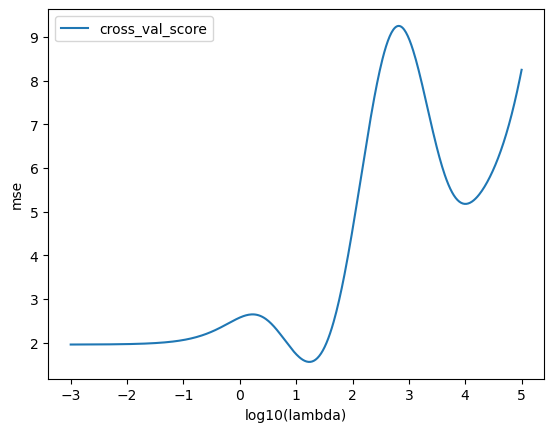

In [37]:
#From lecture notes:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

# Generate the data.
nsamples = 100
x = np.random.randn(nsamples)
y = 3*x**2 + np.random.randn(nsamples)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 6)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)


## Cross-validation using cross_val_score from sklearn along with KFold

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    X = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation
plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.xlabel('log10(lambda)')
plt.ylabel('mse')
plt.legend()

plt.show()

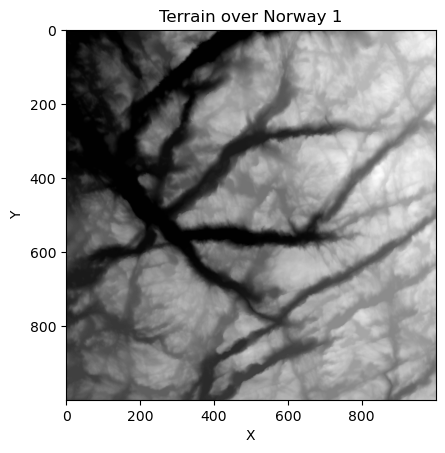

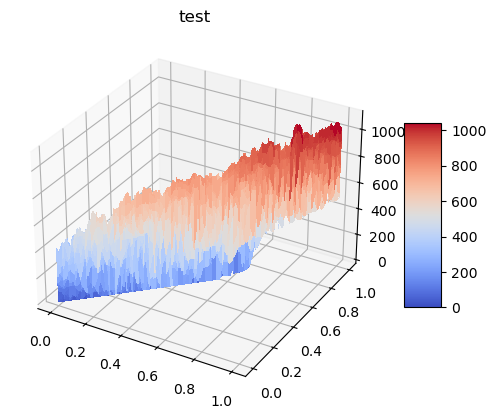

In [27]:
# Load the terrain - again from project description
terrain = imread('SRTM_data_Norway_2.tif')

N = 1000
m = 5 # polynomial order
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)

z = terrain
#X = create_X(x_mesh, y_mesh,m)


# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
